In [1]:
import keras
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
from IPython.display import Image

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
print(keras.__version__)

2.8.0


# Hyperparameters

In [3]:
DATA_FILE_PATH = 'drive/MyDrive/Tutorial/week 9/quora_duplicate_questions.tsv' 
EMB_DIR = 'drive/MyDrive/Tutorial/week 9/glove.6B.50d.txt'

MAX_VOCAB_SIZE = 30000
MAX_SENT_LEN = 15 # HOW WE GOT THIS? I WILL SHOW YOU LATER
EMBEDDING_DIM = 50
BATCH_SIZE = 32
N_EPOCHS = 10

# Preprocessing

In [4]:
df_questions_raw = pd.read_table(DATA_FILE_PATH, sep='\t', nrows=100000)
print('Dataset size:', df_questions_raw.shape)
df_questions_raw

Dataset size: (100000, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
99995,99995,198428,198429,How would you know someone really loves you wh...,How can you know when someone loves you and wh...,0
99996,99996,198430,198431,Who are some of the most gorgeous girls in Vizag?,What is there to see in Vizag for tourists?,0
99997,99997,198432,198433,What is your favourite food? And especially so...,Is honey mustard bad for you? Why or why not?,0
99998,99998,154318,198434,What is the best CDN for users from China?,Is the Fastly CDN blocked in China?,0


#### equalise positives and nagatives

In [5]:
df_questions_raw.is_duplicate.value_counts()

0    62739
1    37261
Name: is_duplicate, dtype: int64

In [6]:
not_same = df_questions_raw[df_questions_raw["is_duplicate"] == 0][:37261]
same = df_questions_raw[df_questions_raw["is_duplicate"] == 1]

df_questions = pd.concat([same, not_same])
df_questions = df_questions.sample(frac=1).reset_index(drop=True) # shuffling

In [7]:
df_questions.is_duplicate.value_counts()

1    37261
0    37261
Name: is_duplicate, dtype: int64

#### delete small and long txts

In [8]:
sent_len = lambda x:len(x)
df_questions['q1_length'] = df_questions.question1.apply(sent_len)
df_questions['q2_length'] = df_questions.question2.apply(sent_len)

df_questions[df_questions['q1_length']<10]['question1']

5910     grammar
6423           ?
19161       I'm 
30685         HH
34553      What?
38000          ?
61431    deleted
72794          .
Name: question1, dtype: object

In [9]:
# Questions having lesser than 10 characters can be discarded. 
indices = set(df_questions[df_questions['q1_length']<10].index).union(df_questions[df_questions['q2_length']<10].index)

df_questions.drop(indices, inplace=True)
df_questions.reset_index()

# Can drop the character count columns - to save memory
df_questions.drop(['q1_length','q2_length'], inplace=True, axis=1)

In [10]:
# THIS IS HOW WE GOT MAX_SENT_LEN = 15

word_count = lambda x:len(x.split()) # Word count for each question
df_questions['q1_wc'] = df_questions.question1.apply(word_count)
df_questions['q2_wc'] = df_questions.question2.apply(word_count)

p = 80.0

print('Question-1 :{} % of the sentences have a length less than or equal to {}'.format(p, np.percentile(df_questions['q1_wc'], 80)))
print('Question-2 :{} % of the sentences have a length less than or equal to {}'.format(p, np.percentile(df_questions['q2_wc'], 80)))

Question-1 :80.0 % of the sentences have a length less than or equal to 14.0
Question-2 :80.0 % of the sentences have a length less than or equal to 14.0


#### Tokenizing

Better to use NLTK tokenizer first and then Keras word to indices.

We can concatinate NLTK tokens with whitespace (" ".joint(...)) and then use keras Tokenizer 


---

Keras will do this : 'what is this?' -> ['what', 'is', 'this?']

NLTK will do this : 'what is this?' -> ['what', 'is', 'this', '?']


In [11]:
%%time
question_list = list(df_questions['question1']) + list(df_questions['question2'])
question_list = [' '.join(word_tokenize(q)[:MAX_SENT_LEN]) for q in question_list]

CPU times: user 22.6 s, sys: 140 ms, total: 22.7 s
Wall time: 36.9 s


In [12]:
question_list[:5]

['Which is the best Oracle training institute in Hyderabad , India ?',
 'Why was the Treaty of Rome significant ?',
 'Can I download the html code of my Weebly site ?',
 'Will Indians face any difficulty if Donald Trump becomes the President of USA ?',
 'How did RBI governor Urjit Patel ’ s signature appear on the new Rs 2,000']

In [13]:
# Filters - except do no removed '?' 
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;<=>@[\\]^_`{|}~\t\n') 
tokenizer.fit_on_texts(question_list)

print("Number of words in vocabulary:", len(tokenizer.word_index))

Number of words in vocabulary: 35859


In [14]:
tokenizer.word_index # It is sorted by frequency.

{'?': 1,
 'the': 2,
 'what': 3,
 'is': 4,
 'how': 5,
 'i': 6,
 'a': 7,
 'to': 8,
 'in': 9,
 'do': 10,
 'are': 11,
 'of': 12,
 'can': 13,
 'and': 14,
 'for': 15,
 'you': 16,
 'why': 17,
 'best': 18,
 'my': 19,
 'on': 20,
 'does': 21,
 'it': 22,
 'which': 23,
 'some': 24,
 'if': 25,
 'be': 26,
 'get': 27,
 "'s": 28,
 'have': 29,
 'your': 30,
 'should': 31,
 'or': 32,
 'that': 33,
 'with': 34,
 'an': 35,
 'from': 36,
 'india': 37,
 'will': 38,
 'people': 39,
 'who': 40,
 'when': 41,
 'good': 42,
 'like': 43,
 'there': 44,
 'would': 45,
 'quora': 46,
 'about': 47,
 'at': 48,
 'between': 49,
 'most': 50,
 'way': 51,
 'as': 52,
 'one': 53,
 'did': 54,
 'we': 55,
 'make': 56,
 "n't": 57,
 'life': 58,
 'where': 59,
 'not': 60,
 'was': 61,
 'by': 62,
 'money': 63,
 'any': 64,
 'learn': 65,
 'after': 66,
 'so': 67,
 'time': 68,
 "''": 69,
 'difference': 70,
 'know': 71,
 'has': 72,
 'trump': 73,
 'think': 74,
 'new': 75,
 'ever': 76,
 'me': 77,
 'they': 78,
 'use': 79,
 'someone': 80,
 'many': 8

In [15]:
# Limit vocab and idx-word dictionary
word_index =  word_index = {k: v for k, v in tokenizer.word_index.items() if v < MAX_VOCAB_SIZE}
idx_to_word = dict((v,k) for k,v in word_index.items())

In [16]:
X = tokenizer.texts_to_sequences(question_list)
X = pad_sequences(X, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

X_q1 = X[:len(X)//2] # First questions
X_q2 = X[len(X)//2:] # Second questions
del X

X_q1[:3]

array([[  23,    4,    2,   18, 2263,  759,  651,    9,  742,   37,    1,
           0,    0,    0,    0],
       [  17,   61,    2, 4058,   12, 4526, 2563,    1,    0,    0,    0,
           0,    0,    0,    0],
       [  13,    6,  335,    2, 1712,  436,   12,   19, 9569,  421,    1,
           0,    0,    0,    0]], dtype=int32)

In [17]:
X_train_q1, X_test_q1, X_train_q2, X_test_q2, y_train, y_test = train_test_split(X_q1,
                                                                                 X_q2,
                                                                                 df_questions['is_duplicate'],
                                                                                 random_state=10, 
                                                                                 test_size=0.1)

# Embedding Matrix


In [18]:
# Load GloVe word embeddings 
# Download Link: https://nlp.stanford.edu/projects/glove/

print("[INFO]: Reading Word Embeddings ...")
# Data path
embeddings = {}
f = open(EMB_DIR)
for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embeddings[word] = vector
f.close()

[INFO]: Reading Word Embeddings ...


In [19]:
# Create an embedding matrix containing only the word's in our vocabulary
# If the word does not have a pre-trained embedding, then randomly initialize the embedding
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

for word, i in word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        
del embeddings

# CNN with Keras Model API

In [20]:
from keras.models import Model
from keras.layers import Layer, Input, Dense, Concatenate, Conv2D, Reshape,  Embedding
from keras.layers import MaxPooling1D, Flatten, BatchNormalization, Activation, Dropout

In [21]:
# Bigram and trigram filters
bi_filter_size = 2
tri_filter_size = 3

num_filters = 20

#### Question 1 Computational Graph


In [22]:


input_1 = Input(shape=(MAX_SENT_LEN, ), name='q1_input')

# Common embedding lookup layer
emb_look_up = Embedding(input_dim=MAX_VOCAB_SIZE,
                        output_dim=EMBEDDING_DIM,
                        weights = [embeddings_matrix], 
                        trainable=False, 
                        mask_zero=False,
                        name='q_embedding_lookup')

emb_1 = emb_look_up(input_1)

# Need to be reshaped because the CONV layer assumes 1 dimnesion as num of channels
emb_1 = Reshape(target_shape=(1, MAX_SENT_LEN, EMBEDDING_DIM), 
                name='q1_embedding_reshape')(emb_1) 

# Convolutional Layers
conv_1_bi =  Conv2D(filters=num_filters, 
                    kernel_size=(bi_filter_size, EMBEDDING_DIM), 
                    padding='valid', 
                    activation='relu', 
                    data_format='channels_first', 
                    name='q1_bigram_conv')(emb_1)

conv_1_tri =  Conv2D(filters=num_filters, 
                     kernel_size=(tri_filter_size, EMBEDDING_DIM), 
                     padding='valid', 
                     activation='relu', 
                     data_format='channels_first', 
                     name='q1_trigram_conv')(emb_1)

# Remove channel dimension before max-pooling operation
bi_out_timesteps = MAX_SENT_LEN - bi_filter_size + 1
tri_out_timesteps = MAX_SENT_LEN - tri_filter_size + 1

conv_1_bi = Reshape(target_shape=(bi_out_timesteps, num_filters), 
                    name='q1_bigram_conv_reshape')(conv_1_bi) # (MAX_SENT_LEN - bi_filter_size + 1, num_filters)
conv_1_tri = Reshape(target_shape=(tri_out_timesteps, num_filters), 
                     name='q1_trigram_conv_reshape')(conv_1_tri)

# Max-pooling Layer
# Pool across timesteps to get 1 feature per filter, i.e., each filter captures 1 feature about the sentence/question
max_pool_1_bi = MaxPooling1D(pool_size = bi_out_timesteps, 
                             name='q1_bigram_maxpool')(conv_1_bi)
max_pool_1_tri = MaxPooling1D(pool_size = tri_out_timesteps, 
                              name='q1_trigram_maxpool')(conv_1_tri)

# Merge the features learnt by bi and tri filters
merged_1 = Concatenate(name='q1_maxpool_concat')([max_pool_1_bi, max_pool_1_tri])
# Inputs dropped out randomly so that there is no heavy dependence on specific features for prediction
dropout_1 = Dropout(rate=0.2, 
                    name='q1_dropout')(merged_1)
flatten_1 = Flatten(name='q1_flatten')(dropout_1)

#### Question 2 Computational Graph


In [23]:


input_2 = Input(shape=(MAX_SENT_LEN, ), name='q2_input')

emb_2 = emb_look_up(input_2)

# Need to be reshaped because the CONV layer assumes 1 dimnesion as num of channels
emb_2 = Reshape((1, MAX_SENT_LEN, EMBEDDING_DIM), 
                name='q2_embedding_reshape')(emb_2)

# Convolutional Layers
conv_2_bi =  Conv2D(filters=num_filters, 
                    kernel_size=(bi_filter_size, EMBEDDING_DIM), 
                    padding='valid', 
                    activation='relu', 
                    data_format='channels_first', 
                    name='q2_bigram_conv')(emb_2)

conv_2_tri =  Conv2D(filters=num_filters, 
                     kernel_size=(tri_filter_size, EMBEDDING_DIM), 
                     padding='valid', 
                     activation='relu', 
                     data_format='channels_first', 
                     name='q2_trigram_conv')(emb_2)

# Remove channel dimension before max-pooling operation
conv_2_bi = Reshape((bi_out_timesteps, num_filters), 
                    name='q2_bigram_conv_reshape')(conv_2_bi) # (MAX_SENT_LEN - bi_filter_size + 1, num_filters)
conv_2_tri = Reshape((tri_out_timesteps, num_filters), 
                     name='q2_trigram_conv_reshape')(conv_2_tri)

# Max-pooling Layer
# Pool across timesteps to get 1 feature per filter, i.e., each filter captures 1 feature about the sentence/question
max_pool_2_bi = MaxPooling1D(pool_size = bi_out_timesteps, 
                             name='q2_bigram_maxpool')(conv_2_bi)
max_pool_2_tri = MaxPooling1D(pool_size = tri_out_timesteps, 
                              name='q2_trigram_maxpool')(conv_2_tri)

# Merge the features learnt by bi and tri filters
merged_2 = Concatenate(name='q2_maxpool_flatten')([max_pool_2_bi, max_pool_2_tri])
# Inputs dropped out randomly so that there is no heavy dependence on specific features for prediction
dropout_2 = Dropout(rate=0.2, 
                    name='q2_dropout')(merged_2)
flatten_2 = Flatten(name='q2_flatten')(dropout_2)

#### Merge outputs of Q1 and Q2


In [24]:
# With batch-normalization, the output of a previous layer is mu-sigma normalized, 
# before it is fed into the next layer. 
# For feed-forward networks, batch-normalization is carried out 
# after/before applying RELU activation (?)
# https://www.reddit.com/r/MachineLearning/comments/67gonq/d_batch_normalization_before_or_after_relu/

merged = Concatenate(name='q1_q2_concat')([flatten_1, flatten_2])

# Dense layers
dense_1 = Dense(units=10, 
                name='q1_q2_dense')(merged)
bn_1 = BatchNormalization(name='batchnorm')(dense_1)
relu_1 = Activation(activation='relu', 
                    name='relu_activation')(bn_1)
dense_1_dropout = Dropout(0.2, 
                          name='dense_dropout')(relu_1)

output_prob = Dense(units=1, 
                    activation='sigmoid', 
                    name='output_layer')(dense_1_dropout)

model = Model(inputs=[input_1, input_2], outputs=output_prob, name='text_pair_cnn')
model.summary()

Model: "text_pair_cnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 q1_input (InputLayer)          [(None, 15)]         0           []                               
                                                                                                  
 q2_input (InputLayer)          [(None, 15)]         0           []                               
                                                                                                  
 q_embedding_lookup (Embedding)  (None, 15, 50)      1500000     ['q1_input[0][0]',               
                                                                  'q2_input[0][0]']               
                                                                                                  
 q1_embedding_reshape (Reshape)  (None, 1, 15, 50)   0           ['q_embedding_lookup[

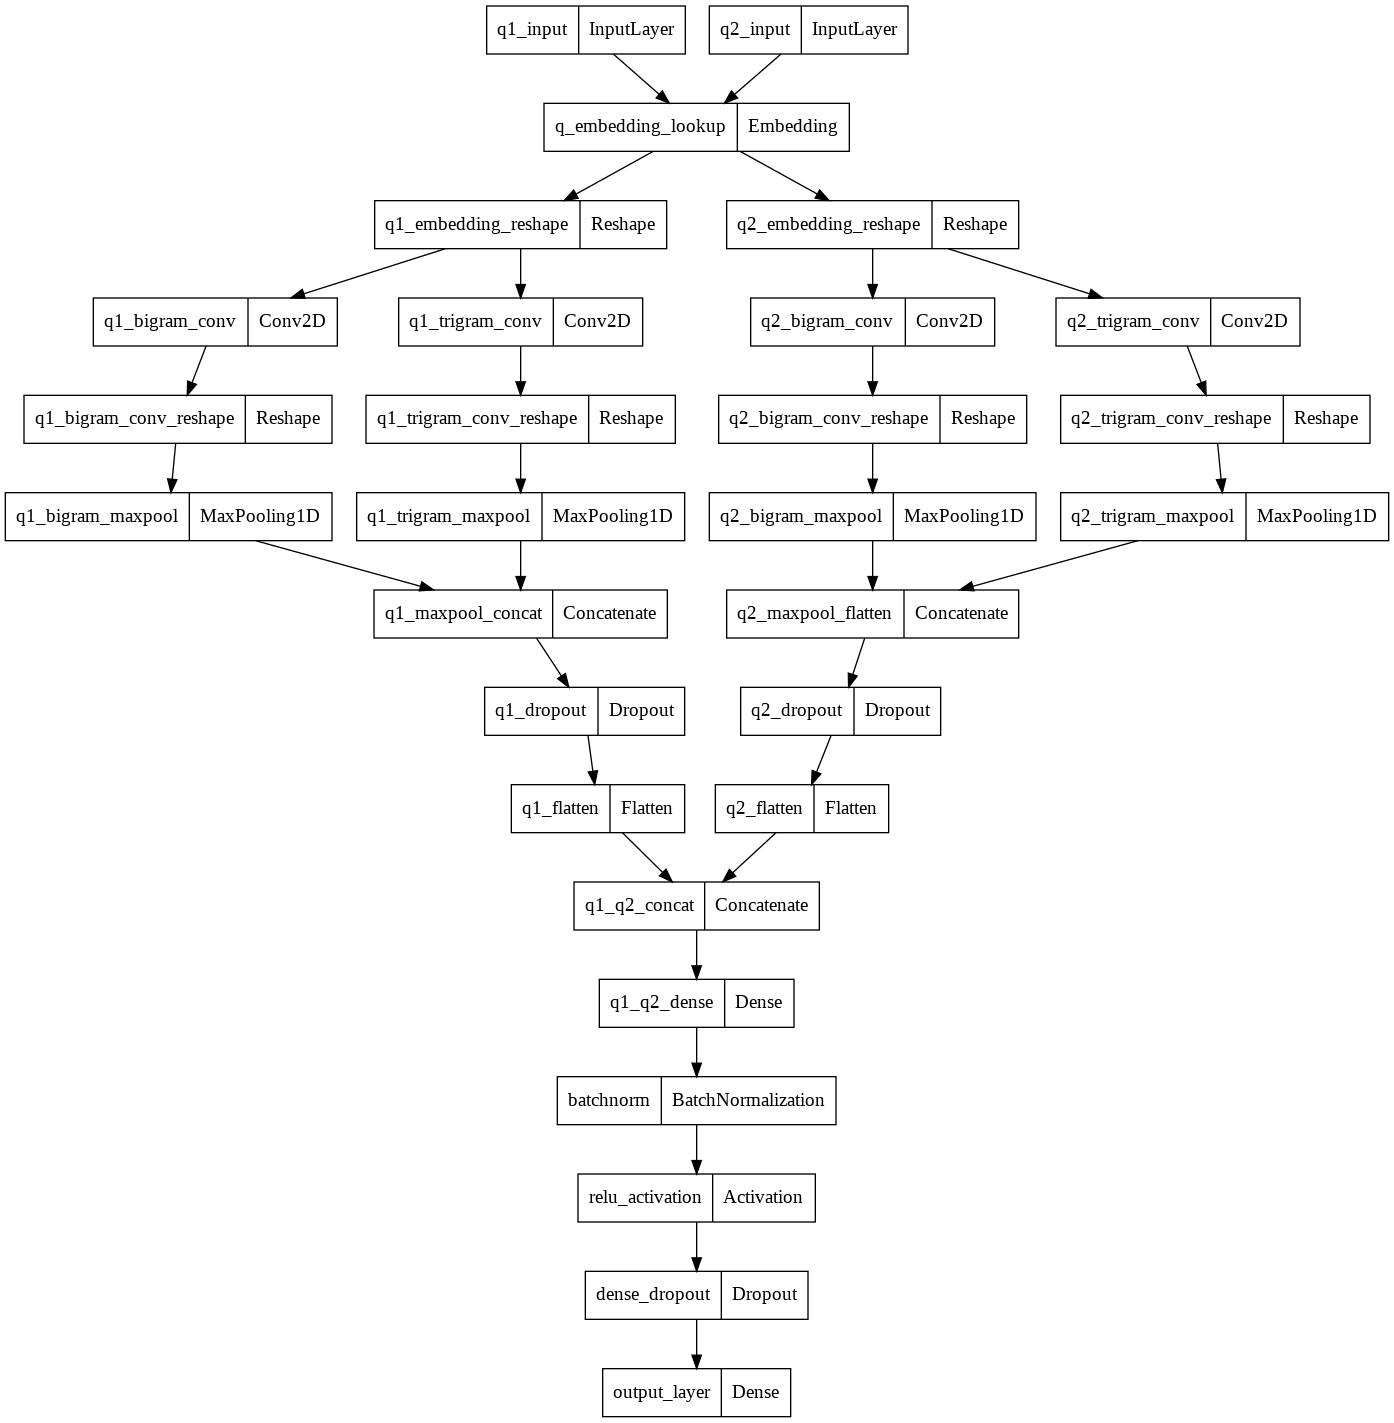

In [25]:
plot_model(model, to_file='text_pair_cnn_classifier.png', show_layer_names=True)
Image('text_pair_cnn_classifier.png')

#### Training the model

In [26]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x = [X_train_q1, X_train_q2], 
          y = y_train, 
          batch_size=BATCH_SIZE, 
          epochs=N_EPOCHS, 
          validation_data=([X_test_q1, X_test_q2], y_test))



Epoch 1/10
2096/2096 [==============================] - 16s 6ms/step - loss: 0.6577 - accuracy: 0.6150 - val_loss: 0.6190 - val_accuracy: 0.6611
Epoch 2/10
2096/2096 [==============================] - 13s 6ms/step - loss: 0.6163 - accuracy: 0.6626 - val_loss: 0.6076 - val_accuracy: 0.6651
Epoch 3/10
2096/2096 [==============================] - 14s 6ms/step - loss: 0.6015 - accuracy: 0.6746 - val_loss: 0.5966 - val_accuracy: 0.6778
Epoch 4/10
2096/2096 [==============================] - 15s 7ms/step - loss: 0.5885 - accuracy: 0.6843 - val_loss: 0.5891 - val_accuracy: 0.6889
Epoch 5/10
2096/2096 [==============================] - 17s 8ms/step - loss: 0.5835 - accuracy: 0.6906 - val_loss: 0.5880 - val_accuracy: 0.6861
Epoch 6/10
2096/2096 [==============================] - 16s 8ms/step - loss: 0.5751 - accuracy: 0.7002 - val_loss: 0.5869 - val_accuracy: 0.6853
Epoch 7/10
2096/2096 [==============================] - 16s 8ms/step - loss: 0.5702 - accuracy: 0.7031 - val_loss: 0.5840 - val_ac

#### Using the model

In [39]:
ques_pairs = [
                   ("How to make a youtube video?", "How can I make a youtube video?"),
                   ("what is a car?", "where can I find some green apples?"),
]

In [40]:
def txt_to_indx(txt):
  ret = [txt] # to make it a list
  ret = tokenizer.texts_to_sequences(ret)
  ret = pad_sequences(ret, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
  return ret


txt_to_indx("text to index function will do this")

array([[ 845,    8, 3812,  688,   38,   10,  100,    0,    0,    0,    0,
           0,    0,    0,    0]], dtype=int32)

In [41]:
indx_ques_pairs = [(txt_to_indx(i[0]), txt_to_indx(i[1])) for i in ques_pairs]


for i in indx_ques_pairs:
  print(model.predict(i)[0][0] > 0.6)

True
False



Notes

    This model does not consider interation between sentences
    We could include some attention mechanisms
    CNN Siamese Architectures
    Design and input hand-crafted features along with CNN learnt features at the dense layer


Code by HareeshBahuleyan